<a href="https://colab.research.google.com/github/Chubbyman2/GAN_Waifu_Generator/blob/main/GAN_Waifu_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import PIL
import time
from tqdm import tqdm
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, Input, LeakyReLU, Reshape

# Import Dataset

In [ ]:
import zipfile
from google.colab import drive
drive.mount('/content/drive/')

!unzip "/content/drive/My Drive/waifus.zip"

In [3]:
# Number of waifu images
dir = "waifus/"
waifu_list = os.listdir(dir)
img_count = len(waifu_list)
img_count

63633

In [4]:
# Size of waifu images (square imgs, so same height and width)
smallest_width = 100
all_widths = []

for waifu_img in waifu_list:
  try:
    sample_img = PIL.Image.open(f"waifus/{waifu_img}")
    all_widths.append(sample_img.size[0])
    if smallest_width > sample_img.size[0]:
      smallest_width = sample_img.size[0]
  except: # UnidentifiedImageError, idk why this happens
    pass

# Shows smallest width and median width
smallest_width, all_widths[int(img_count/2)]

(25, 88)

In [5]:
# Converts them all to 64x64, normalizes images
# Has to be 64, otherwise shape error in model
width = 64
height = 64
images = []

for pic_file in tqdm(os.listdir(dir)[:img_count]):
  try:
    pic = PIL.Image.open(dir + pic_file).resize((width, height))
    pic.thumbnail((width, height), PIL.Image.ANTIALIAS)
    images.append(np.uint8(pic)) # Normalizes images
  except:
    pass

images = np.array(images)/255
images.shape

100%|██████████| 63633/63633 [00:33<00:00, 1908.77it/s]


(63569, 64, 64, 3)

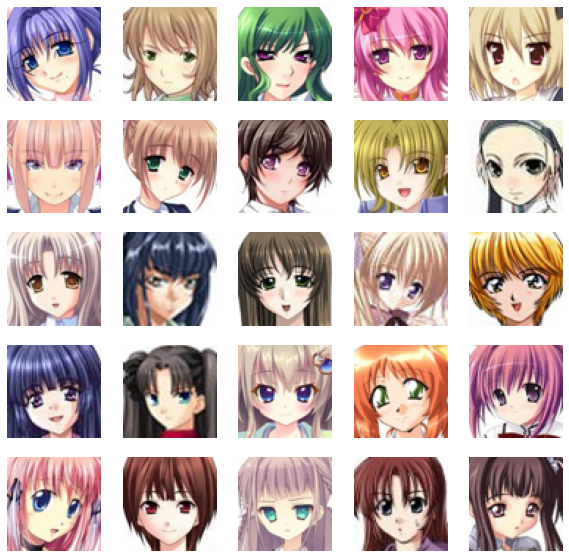

In [6]:
# Display first 25 resized waifu images
plt.figure(1, figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(images[i])
  plt.axis("off")
plt.show()

# Generator

In [7]:
latent_dim = 32
channels = 3

def create_generator():
  gen_input = Input(shape=(latent_dim, ))

  # If shape error occurs, adjust values here
  x = Dense(64 * 8 * 8)(gen_input)
  x = LeakyReLU()(x)
  x = Reshape((8, 8, 64))(x)
  
  x = Conv2D(256, 5, padding='same')(x)
  x = LeakyReLU()(x)
  
  x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
  x = LeakyReLU()(x)
  
  x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
  x = LeakyReLU()(x)
  
  x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
  x = LeakyReLU()(x)
  
  x = Conv2D(512, 5, padding='same')(x)
  x = LeakyReLU()(x)
  x = Conv2D(512, 5, padding='same')(x)
  x = LeakyReLU()(x)
  x = Conv2D(channels, 7, activation='tanh', padding='same')(x)
  # print(x.shape)
  
  generator = Model(gen_input, x)
  return generator

# Discriminator

In [8]:
def create_discriminator():
  dis_input = Input(shape=(height, width, channels))
  
  x = Conv2D(256, 3)(dis_input)
  x = LeakyReLU()(x)
  
  x = Conv2D(256, 4, strides=2)(x)
  x = LeakyReLU()(x)
  
  x = Conv2D(256, 4, strides=2)(x)
  x = LeakyReLU()(x)
  
  x = Conv2D(256, 4, strides=2)(x)
  x = LeakyReLU()(x)
  
  x = Conv2D(256, 4, strides=2)(x)
  x = LeakyReLU()(x)
  
  x = Flatten()(x)
  x = Dropout(0.4)(x)
  
  x = Dense(1, activation='sigmoid')(x)
  discriminator = Model(dis_input, x)
  
  optimizer = RMSprop(
      lr=.0001,
      clipvalue=1.0,
      decay=1e-8
  )
  
  discriminator.compile(
      optimizer=optimizer,
      loss='binary_crossentropy'
  )
  
  return discriminator

# GAN Model

In [9]:
generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False
gan_input = Input(shape=(latent_dim, ))
gan_output = discriminator(generator(gan_input))

# GAN Model
gan = Model(gan_input, gan_output)
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

# Training Process

In [17]:
iters = 25000
batch_size = 16
res_dir = '/content/waifus'
file_path = '%s/generated_%d.png'
if not os.path.isdir(res_dir):
    os.mkdir(res_dir)
control_size_sqrt = 6
control_vectors = np.random.normal(size=(control_size_sqrt**2, latent_dim)) / 2
start = 0
d_losses = []
a_losses = []
images_saved = 0

In [18]:
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    generated = generator.predict(latent_vectors)
    
    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])
    
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)
    
    latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)
    
    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0
    
    if step % 50 == 49:
        gan.save_weights('gan.h5')
        
        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.' % (step + 1, iters, d_loss, a_loss))
        
        control_image = np.zeros((width * control_size_sqrt, height * control_size_sqrt, channels))
        control_generated = generator.predict(control_vectors)
        for i in range(control_size_sqrt ** 2):
            x_off = i % control_size_sqrt
            y_off = i // control_size_sqrt
            control_image[x_off * width:(x_off + 1) * width, y_off * height:(y_off + 1) * height, :] = control_generated[i, :, :, :]
        im = PIL.Image.fromarray(np.uint8(control_image * 255))
        im.save(file_path % (res_dir, images_saved))
        images_saved += 1

50/25000: d_loss: 0.5863,  a_loss: 0.6147.
100/25000: d_loss: 0.6583,  a_loss: 1.2314.
150/25000: d_loss: 0.5816,  a_loss: 0.7558.
200/25000: d_loss: 0.5919,  a_loss: 1.0198.
250/25000: d_loss: 0.6796,  a_loss: 1.0698.
300/25000: d_loss: 0.6098,  a_loss: 1.3996.
350/25000: d_loss: 0.5763,  a_loss: 0.8721.
400/25000: d_loss: 0.6118,  a_loss: 1.0228.
450/25000: d_loss: 0.6405,  a_loss: 0.9096.
500/25000: d_loss: 0.6808,  a_loss: 1.1318.
550/25000: d_loss: 0.6275,  a_loss: 1.2380.
600/25000: d_loss: 0.6824,  a_loss: 1.2248.
650/25000: d_loss: 0.5717,  a_loss: 1.0495.
700/25000: d_loss: 0.6609,  a_loss: 1.1344.
750/25000: d_loss: 0.6653,  a_loss: 1.0010.
800/25000: d_loss: 0.6592,  a_loss: 1.0262.
850/25000: d_loss: 0.7624,  a_loss: 1.7559.
900/25000: d_loss: 0.6355,  a_loss: 1.2829.
950/25000: d_loss: 0.7420,  a_loss: 1.2735.
1000/25000: d_loss: 0.6577,  a_loss: 0.8373.
1050/25000: d_loss: 0.6405,  a_loss: 0.9996.
1100/25000: d_loss: 0.6714,  a_loss: 1.0937.
1150/25000: d_loss: 0.5541,  a

# Visualize Results

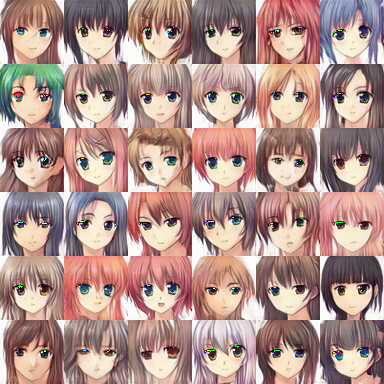

In [19]:
from IPython.display import Image 
Image('/content/waifus/generated_1.png')

In [20]:
if not os.path.exists("/content/cropped/"):
  os.mkdir("/content/cropped/")
if not os.path.exists("/content/originals/"):
  os.mkdir("/content/originals/")

In [21]:
for filename in os.listdir("/content/waifus"):
  n = 1
  m = n
  dim = 384/6 # Width and height of each small image
  if filename.endswith(".png"):
    pic = PIL.Image.open("/content/waifus/" + filename)
    pic_width, pic_height = pic.size
    # print(f"Width: {pic_width}, Height: {pic_height}")

    # Save original image to a separate folder so it doesn't get deleted when creating gif
    og_img = pic.copy()
    try:
      og_img.save(f"/content/originals/{filename}")
    except FileNotFoundError:
      print(f"{filename} not found. Skipping...")
      pass

  # 6x6 = 36 images per processed image, crop each of these out and save them
  for i in range(6): # Width
    for j in range(6): # Height
      new_pic = pic.copy().crop((0 + j*dim, 0 + i*dim, (j+1)*dim, (i+1)*dim))
      new_pic.save(f"/content/cropped/generated_{n}_{m}.png")
      m += 1

      # pic_cropped_width, pic_cropped_height = pic.size
      # print(f"Width: {pic_cropped_width}, Height: {pic_cropped_height}")

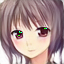

In [31]:
# Displays one of the randomly generated waifu pics
import random
Image("/content/cropped/" + random.choice([waifu for waifu in os.listdir("/content/cropped")]))

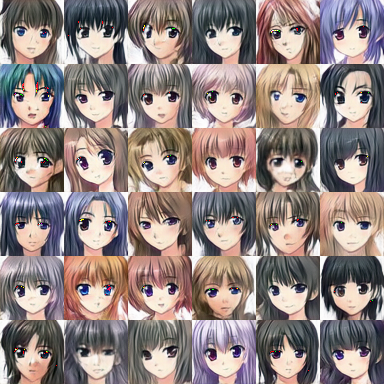

In [32]:
# Displays one of the original 36-image saves
Image("/content/originals/" + random.choice([waifu for waifu in os.listdir("/content/originals")]))

In [51]:
# This will create the gif
import imageio
import shutil
images_to_gif = []
for filename in os.listdir(res_dir):
  if filename.endswith(".png"):
    try:
      images_to_gif.append(imageio.imread(res_dir + "/" + filename))
    except:
      pass 
imageio.mimsave('training_visual.gif', images_to_gif)
shutil.rmtree(res_dir)

In [33]:
# Loss values
a_loss_start_avg = 0
a_loss_end_avg = 0
d_loss_start_avg = 0
d_loss_end_avg = 0

for a_loss in a_losses[:1000]:
  a_loss_start_avg += a_loss

for a_loss in a_losses[-1000:]:
  a_loss_end_avg += a_loss

for d_loss in d_losses[:1000]:
  d_loss_start_avg += d_loss

for a_loss in a_losses[-1000:]:
  d_loss_end_avg += d_loss

a_loss_start_avg /= 1000
a_loss_end_avg /= 1000
d_loss_start_avg /= 1000
d_loss_end_avg /= 1000

print(f"Initial Generator Loss: {a_loss_start_avg}, Initial Discriminator Loss: {d_loss_start_avg}")
print(f"Final Generator Loss: {a_loss_end_avg}, Final Discriminator Loss: {d_loss_end_avg}")

Initial Generator Loss: 1.020249516248703, Initial Discriminator Loss: 0.6536713623404503
Final Generator Loss: 1.156013769686222, Final Discriminator Loss: 0.6576919555664062


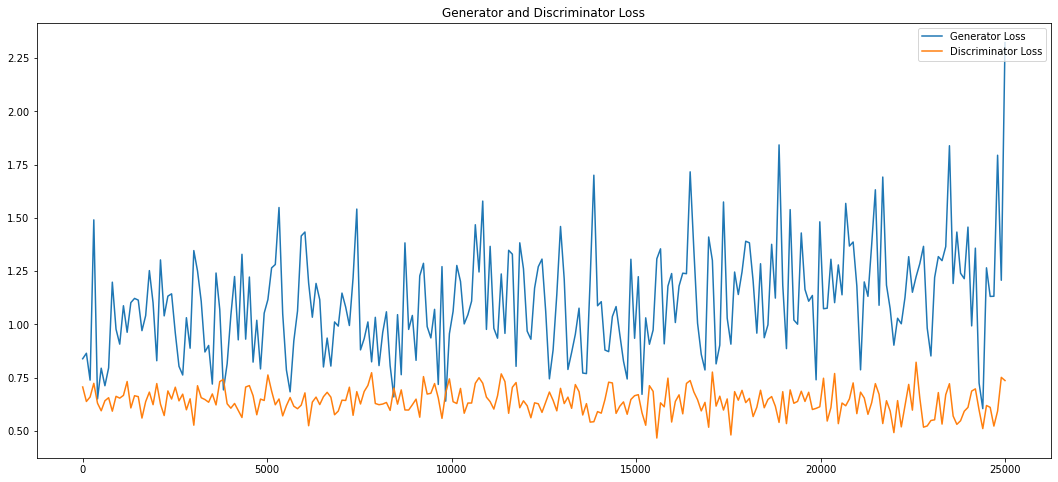

In [50]:
# Loss graphs
from scipy.interpolate import make_interp_spline, BSpline
# epochs_range = range(iters)

epochs_range = []
for i in range(1, 25001):
  epochs_range.append(i)
epochs_range = np.array(epochs_range)

plt.figure(figsize=(40,8))
plt.subplot(1, 2, 2)

epochs_new = np.linspace(epochs_range.min(), epochs_range.max(), 250) 

spl_a = make_interp_spline(epochs_range, a_losses, k=5)
a_smooth = spl_a(epochs_new)

spl_d = make_interp_spline(epochs_range, d_losses, k=5)
d_smooth = spl_d(epochs_new)

plt.plot(epochs_new, a_smooth, label="Generator Loss")
plt.plot(epochs_new, d_smooth, label="Discriminator Loss")

# plt.plot(epochs_range, a_losses, label="Generator Loss")
# plt.plot(epochs_range, d_losses, label="Discriminator Loss")
plt.legend(loc="upper right")
plt.title("Generator and Discriminator Loss")
plt.savefig("./foo.png")
plt.show()

In [ ]:
# Download images as zip files, if you want to
!zip -r /content/originals.zip /content/originals
!zip -r /content/cropped.zip /content/cropped

from google.colab import files
files.download("/content/originals.zip")
files.download("/content/cropped.zip")
files.download("/content/training_visual.gif")

In [ ]:
# Other useful code

# Delete all files in waifus directory, if needed
'''
for filename in os.listdir(res_dir):
  os.unlink(res_dir + "/" + filename)
'''

# Check if file exists
'''
os.path.isfile(res_dir + "/" "10884_2005.jpg")
'''